# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way ensure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import progressbar
import time
import os
from pydash.arrays import chunk

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [3]:
# Show df to get an idea of the data
print(df.shape)
df.head()

(45993, 3)


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
print(df_content.shape)
df_content.head()

(1056, 5)


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# The number of unique users in dataset
print("number of unique users in df:", df['email'].nunique())

# The number of unique articles in dataset
print("number of unique articles in df:", df['article_id'].nunique())

number of unique users in df: 5148
number of unique articles in df: 714


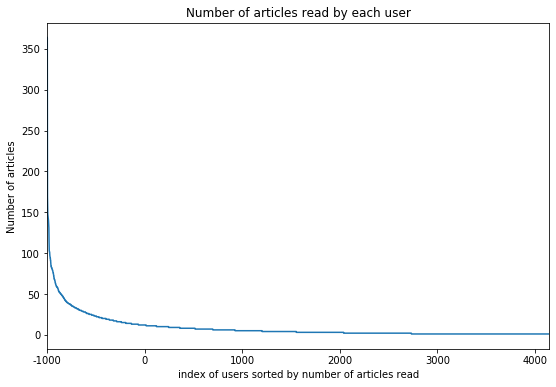

In [6]:
# The distribution of articles read by each user
val_count = df.groupby(['email']).size()
val_count = val_count.sort_values(0,ascending=False)


ax = val_count.plot(color='#1F77B4', title='Number of articles read by each user', figsize=(9,6));
ax.set_ylabel("Number of articles")
ax.set_xlabel("index of users sorted by number of articles read")
ax.set_xticklabels(np.arange(-1000,len(val_count),1000))
plt.show()

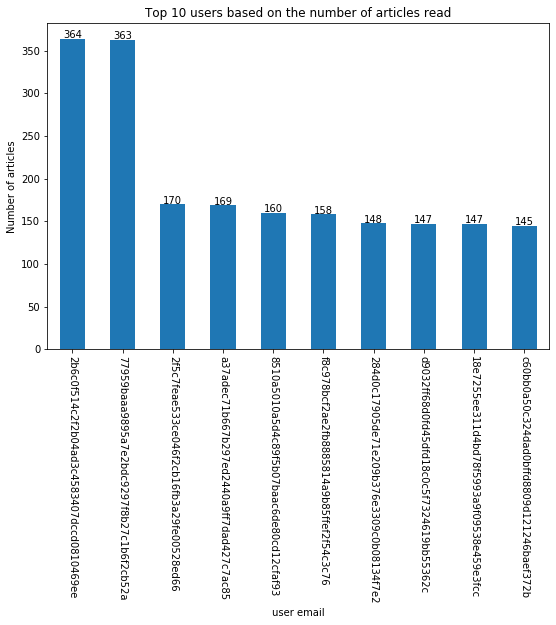

In [7]:
# The distribution of articles read by each user
val_count = df.groupby(['email']).size()
num_users = 10
rotation = 270
val_count = val_count.sort_values(0,ascending=False)
val_count = val_count[:num_users]


ax = val_count.plot(kind="bar", color='#1F77B4', title='Top 10 users based on the number of articles read', figsize=(9,6));
for y, x in enumerate(val_count.values):
    plt.annotate(str(round(x,0)), xy=(y, x+0.5), ha="center")
ax.set_ylabel("Number of articles")
ax.set_xlabel("user email")
plt.xticks(rotation=rotation)
plt.show()

In [8]:
# obtain median of series
val_count = df.groupby(['email']).size()
val_count.median()

3.0

In [9]:
# obtain median of series using describe() function
val_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
dtype: float64

In [10]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles
print("df_content.shape: ", df_content.shape)

# The number of unique articles in dataset
print("number of unique articles in df_content: ", df_content['article_id'].nunique())

# check the number of duplicates
print("Number of duplicate rows in df_content:", df_content.duplicated().sum())

# check the number of duplicates based on article_id
print("Number of duplicate article_ids in df_content:", df_content['article_id'].duplicated().sum())

# Show duplicate rows
df_content[df_content['article_id'].duplicated()]

df_content.shape:  (1056, 5)
number of unique articles in df_content:  1051
Number of duplicate rows in df_content: 0
Number of duplicate article_ids in df_content: 5


,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [12]:
# Remove any rows that have the same article_id - keeping only the first
df_mask = df_content[df_content['article_id'].duplicated()]
df_content.drop(df_mask.index[:], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [13]:
# The number of unique articles that have an interaction with a user.
print("The unique articles with user interaction:", df['article_id'].nunique())

# The number of unique articles in the dataset (whether they have any interactions or not)
print("Number of unique articles:", df_content['article_id'].nunique())

# The number of unique users in the dataset. (excluding null values)
print("The number of unique users in the dataset:", df['email'].nunique())

# The number of user-article interactions in the dataset.
print("The number of user-article interactions:", df.shape[0])

The unique articles with user interaction: 714
Number of unique articles: 1051
The number of unique users in the dataset: 5148
The number of user-article interactions: 45993


In [14]:
# check the number of duplicates in df
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 12311


In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found using other information, that all of these null values likely belonged to a single user.

In [16]:
val_count = df.groupby(['article_id']).size()
val_count = val_count.sort_values(0,ascending=False)
print("Most viewed article_id:", val_count.index[0])
print("Number of times viewed:", val_count.iloc[0])

Most viewed article_id: 1429.0
Number of times viewed: 937


In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [20]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    val_count = df.groupby(['article_id']).size()
    val_count = val_count.sort_values(0,ascending=False)
    top_articles = []
    for i in range(len(val_count.index[:n])):
        mask = df['article_id']==val_count.index[i]
        top_articles.append(df[mask]['title'].iloc[0])
    
    return top_articles # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Your code here
    val_count = df.groupby(['article_id']).size()
    val_count = val_count.sort_values(0,ascending=False)
    top_articles = list(val_count.index[:n])
    top_articles = [str(x) for x in top_articles]
 
    return top_articles # Return the top article ids

In [21]:
print(get_top_articles(5))
print(get_top_article_ids(5))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0']


In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1 (therefore can drop duplicates).  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Drop duplicates
    df.drop_duplicates(inplace=True)
    df = df[['user_id', 'article_id']]
    
    df['value'] = [1 for i in range(df.shape[0])]
    user_item = df.groupby(['user_id', 'article_id'])['value'].max().unstack()
        
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df.copy())

In [24]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [25]:
user_item.head(3)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`2.` Complete the function below which should take a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the row for each user is binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
def articles_read(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    user_item - is the user_id by article_id matrix dataframe
    
    OUTPUT:
    articles - an array of article_ids the user has read
    '''
    # when row is selected column labels become index
    row_mask = user_item.loc[user_id].isnull() == False
    articles = user_item.loc[user_id][row_mask].index.values
    
    return articles

# Create a dictionary for a user_id with corresponding articles read
def create_user_article_dict(user_item=user_item):
    '''
    INPUT:
    user_item - is the user_id by article_id matrix
    
    OUTPUT: 
    articles_seen - a dictionary where each key is a user_id and the value is an array of article_ids
    
    Creates the articles_seen dictionary
    '''
    
    # set up a progress bar to monitor progress
    num_users = user_item.shape[0]
    articles_seen = dict()

    # Set up a progress bar
    cnter = 0
    bar = progressbar.ProgressBar(maxval=num_users+1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()

    for user in range(1, num_users+1):
        
        # update progress bar
        cnter+=1 
        bar.update(cnter)
        
        # assign list of movies to each user key
        articles_seen[user] = articles_read(user)
        
    bar.finish()
    
    return articles_seen

In [27]:
# Use your function to return dictionary
articles_to_analyze = create_user_article_dict()

[========================================================================] 100%


In [28]:
def compute_dot_product(user1, user2, user_item, articles_to_analyze=articles_to_analyze):
    '''
    INPUT
    user1 - (int) user_id
    user2 - (int) user_id
    user_item - (dataframe) the user_id by article_id matrix
    articles_to_analyze - (dict) has userids as keys and articles seen by a userid as value  
    
    OUTPUT
    dist - (int) the similarity score between user1 and user2
    
    '''
    # Get articles for each user. Users have to exist!
    articles1 = articles_to_analyze[user1]
    articles2 = articles_to_analyze[user2]
    
    
    # Find common articles
    common_articles = np.intersect1d(articles1, articles2, assume_unique=True)
    
    # Check if common_articles exists, else similarity is zero
    if not len(common_articles):
        return 0
    
    df = user_item.loc[(user1, user2), common_articles]

    if user1 == user2:
        return np.dot(df.loc[user1].values[0], df.loc[user2].values[0])
   
    dist = np.dot(df.loc[user1].values, df.loc[user2].values)
    return dist #return the dot product

def compute_similarity(user_id, user_item, articles_to_analyze=articles_to_analyze):
    '''
    INPUT
    user_id - (int) A user id
    user_item - (dataframe) the user_id by article_id matrix
    articles_to_analyze - (dict) of articles seen by users

    OUTPUT
    dist_array - (array) containing similarity scores relative to user_id
    '''
    i = 0
    dist_array = np.zeros((len(user_item.index), 3))
    for user in user_item.index:
        dist_array[i,0] = user_id
        dist_array[i,1] = user
        dist_array[i,2] = compute_dot_product(user_id, user, user_item, articles_to_analyze)
        i+=1
    return dist_array

In [29]:
def find_similar_users(user_id, user_item=user_item, articles_to_analyze=articles_to_analyze):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    # compute similarity of each user to the provided user
    dist_array_min = compute_similarity(user_id, user_item, articles_to_analyze)
    
    # create dataframe from array
    df_dists_min = pd.DataFrame(data=dist_array_min, columns=['user1', 'user2', 'similarity'])

    # sort by similarity
    temp_df = df_dists_min.sort_values(by='similarity', ascending=False)

    # create list of just the ids
    # closest_users = list(temp_df['user2'])
   
    # remove the input user's id
    closest_users = temp_df[temp_df.user2 != user_id]['user2']
    most_similar_users = list(closest_users)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933.0, 23.0, 3782.0, 203.0, 4459.0, 3870.0, 131.0, 4201.0, 46.0, 5041.0]
The 5 most similar users to user 3933 are: [1.0, 23.0, 3782.0, 203.0, 4459.0]
The 3 most similar users to user 46 are: [4201.0, 3782.0, 23.0]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    mask = df['article_id'].isin(article_ids)
    temp_df = df[mask]['title'].drop_duplicates()
    article_names = list(temp_df)
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = articles_read(user_id, user_item=user_item)
    article_ids = list(map(str,article_ids))
    article_names = list(get_article_names(article_ids, df=df))
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # Get users close to user_id
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    # Get articles viewed by user_id
    user_id_articles, _ = get_user_articles(user_id, user_item=user_item)
    
    # for recommended articles
    recs = np.array([])
    
    for sim_user in similar_users:
        # Get articles viewed by sim_user
        sim_user_articles, _ = get_user_articles(sim_user, user_item=user_item)
                
        # remove articles already seen by user_id
        new_recs = np.setdiff1d(sim_user_articles, user_id_articles, assume_unique=True)
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([recs, new_recs], axis=0))
        
        # If there's enough recommendations exit the loop
        if len(recs) >= m:
            recs = recs[:m]
            break
    
    return recs # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['analyze energy consumption in buildings',
 'analyze accident reports on amazon emr spark',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'airbnb data for analytics: vancouver listings',
 'recommender systems: approaches & algorithms',
 'airbnb data for analytics: mallorca reviews',
 'analyze facebook data using ibm watson and watson studio',
 'a tensorflow regression model to predict house values']

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item, articles_to_analyze=articles_to_analyze):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''   
    
    # Your code here
    # compute similarity of each user to the provided user
    dist_array = compute_similarity(user_id, user_item, articles_to_analyze)
    
    # eliminate unwanted column
    dist_array = dist_array[:,1:]
    
    # create the num_interactions column
    num_array = np.zeros((len(dist_array),1))
    for i in range(len(dist_array)):
        num_array[i] = len(articles_to_analyze[dist_array[i,0]])
    
    dist_array = np.concatenate((dist_array,num_array), axis=1)
    
    # create dataframe from array
    df_dists = pd.DataFrame(data=dist_array, columns=['neighbor_id', 'similarity', 'num_interactions'])

    # sort by similarity, breaking tie with the number of user-article interactions
    temp_df = df_dists.sort_values(['similarity', 'num_interactions'], ascending=False)
   
    # remove the given user_id
    neighbors_df = temp_df[temp_df.neighbor_id != user_id]
    
    return neighbors_df # Return the dataframe specified in the doc_string

def get_article_interaction(article_id, df=df):
    '''
    INPUT:
    article_id - (int) an article's id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    interaction_count - (int) number of interactions an article_id has.
    
    '''
    # Your code here
    val_count = df.groupby(['article_id']).size()
    interaction_count = val_count.loc[article_id]
    
    return interaction_count



def user_user_recs_part2(user_id, m=10, df=df, user_item=user_item, articles_to_analyze=articles_to_analyze):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # Get users close to user_id, sorted by their article interactions
    top_sorted_users = get_top_sorted_users(user_id, df=df, user_item=user_item, articles_to_analyze=articles_to_analyze)
    closest_users = top_sorted_users['neighbor_id']
    similar_users = list(closest_users)
      
    # Get articles viewed by user_id
    user_id_articles, _ = get_user_articles(user_id, user_item=user_item)
    
    # for recommended articles
    recs = np.array([])
    
    for sim_user in similar_users:
        # Get articles viewed by similar user
        sim_user_articles, _ = get_user_articles(sim_user, user_item=user_item)
                
        # remove articles already seen by user_id
        new_recs = np.setdiff1d(sim_user_articles, user_id_articles, assume_unique=True)
    
        # Check if number of articles exceed the input m
        if len(recs) + len(new_recs) > m:
            
            # create the column to be used for sorting
            sort_array = np.zeros((len(new_recs),1))
            
            for i, new_rec in enumerate(new_recs):
                # get the number of article interactions for each article_id
                sort_array[i] = get_article_interaction(new_rec.astype(np.float), df=df)
                
            new_recs = np.concatenate((new_recs.reshape(-1,1), sort_array), axis=1)
            
            # sort descending
            new_recs = new_recs[new_recs[:,1].argsort()[::-1]]
            new_recs = new_recs[:,0]
        
        # Update recs with new recs
        recs = np.unique(np.concatenate([recs, new_recs], axis=0))
        
        # If we have enough recommendations exit the loop
        if len(recs) >= m:
            recs = recs[:m]
            break
    
    rec_names = get_article_names(recs, df=df)
    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
rec_names

The top 10 recommendations for user 20 are the following article ids:
['1014.0' '1059.0' '109.0' '111.0' '1157.0' '1162.0' '1164.0' '1172.0'
 '1186.0' '12.0']

The top 10 recommendations for user 20 are the following article names:


['timeseries data analysis of iot events by using jupyter notebook',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'apache spark lab, part 3: machine learning',
 'airbnb data for analytics: washington d.c. listings',
 'airbnb data for analytics: amsterdam calendar',
 'tidy up your jupyter notebooks with scripts',
 'tensorflow quick tips',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'connect to db2 warehouse on cloud and db2 using scala']

In [36]:
# using previous user_user_recs function
list(user_user_recs(20, 10))

['1052.0',
 '1059.0',
 '1161.0',
 '1162.0',
 '1163.0',
 '1164.0',
 '1169.0',
 '1172.0',
 '1173.0',
 '1175.0']

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [37]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item, articles_to_analyze=articles_to_analyze).iloc[0,0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item, articles_to_analyze=articles_to_analyze).iloc[10,0] # Find the 10th most similar user to user 131

In [38]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user the rank based approach would be the preferred option. The collaborative filltering technique only works when a user has made atleast one interaction with an existing article. The functions that could be used to make the recommendation for a new user are the get_top_articles() and the get_top_article_ids() functions.

In the above analysis a significant amount of information has been discarded by not considering the number of times a user has interacted with a specific article. Such additional data could potentially improve the performance of the recommendation engine.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [39]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10, df=df) # Your recommendations here

In [40]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [41]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [43]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [44]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
def user_item_para(user_item_matrix):
    '''
    INPUT:
    user_item_matrix - (dataframe) a user-item matrix
    
    OUTPUT:
    None
    
    Description:
    Prints the shape and the number of nulls in the input matrix.
   
    '''
    # shape of dataframe
    print("shape:", user_item_matrix.shape)

    # The number of nulls in dataframe
    print("number of nulls:", sum(user_item_matrix.isnull().sum()))
user_item_para(user_item_matrix)

shape: (5149, 714)
number of nulls: 0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

print(s.shape, u.shape, vt.shape)

(714,) (5149, 5149) (714, 714)


**Provide your response here.**

The noted difference in the above is that the dimension of the composite matrices U, S, and VT is different which is caused by the user_item matrix having a different dimension than the matrix in the lessons. The reason why the decomposition works in this case is that there is no null value in the user item matrix being decomposed above, otherwise the decomposition would fail.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

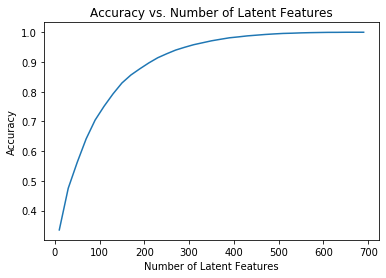

In [47]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
# df.shape[0]: is norm and indicates the number of 1s?    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [49]:
print(user_item_train.shape)
print(user_item_test.shape)

(4487, 714)
(682, 574)


In [50]:
# How many users can we make predictions for in the test set?
train_users = user_item_train.index
num_test_pred = len(list(set(train_users).intersection(set(test_idx))))
print("users predictable:", num_test_pred)

# How many users in the test set are we not able to make predictions for because of the cold start problem?
print("users unpredictable:", len(test_idx) - num_test_pred)

# How many articles can we make predictions for in the test set?
train_articles = user_item_train.columns
num_test_pred = len(list(set(train_articles).intersection(set(test_arts))))
print("articles predictable:", num_test_pred)

# How many articles in the test set are we not able to make predictions for because of the cold start problem?
print("articles unpredictable:", len(test_arts) - num_test_pred)

users predictable: 20
users unpredictable: 662
articles predictable: 574
articles unpredictable: 0


In [51]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [52]:
user_item_para(user_item_train)

# To ensure svd converges
user_item_train.fillna(0.0, inplace=True)

# For validation
user_item_test.fillna(0.0, inplace=True)

user_item_para(user_item_train)

shape: (4487, 714)
number of nulls: 3174454
shape: (4487, 714)
number of nulls: 0


In [53]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below
print(u_train.shape, s_train.shape, vt_train.shape)

(4487, 4487) (714,) (714, 714)


In [54]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [55]:
# get list of user positions in user_item_train eligible for error computation
train_users = user_item_train.index
train_articles = user_item_train.columns

# Identify the users in the test set that are also in the training. 
# Users in the test set that are also in the training set are represented by the indices in list_user_idx
list_user_idx = list(set(train_users).intersection(set(test_idx)))
user_positions_list = []
for user_idx in list_user_idx:
    temp = user_item_train.index.get_loc(user_idx)
    user_positions_list.append(temp)
    
# get list of article positions in user_item_train eligible for error computation
list_article_idx = list(set(train_articles).intersection(set(test_arts)))
article_positions_list = []
for article_idx in list_article_idx:
    temp = user_item_train.columns.get_loc(article_idx)
    article_positions_list.append(temp)


# iterate through different latent feature values
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []
sum_errs_train = []
for i, k in enumerate(num_latent_feats):
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each test prediction to actual value
    diffs = np.subtract(user_item_test.loc[list_user_idx, list_article_idx], \
                        user_item_est[user_positions_list][:, article_positions_list])
    
    # compute error for each train prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    
    sum_errs.append(err)
    sum_errs_train.append(err_train)    

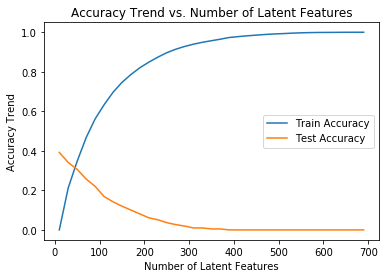

In [56]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/max(sum_errs_train), label='Train Accuracy')
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/max(sum_errs), label='Test Accuracy')
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy Trend');
plt.title('Accuracy Trend vs. Number of Latent Features');
plt.legend(frameon=True)
plt.show()

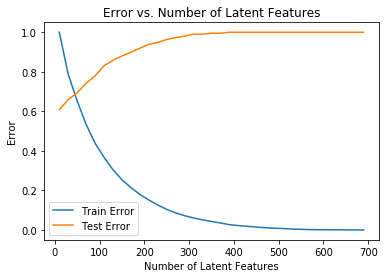

In [57]:
plt.plot(num_latent_feats, np.array(sum_errs_train)/max(sum_errs_train), label='Train Error')
plt.plot(num_latent_feats, np.array(sum_errs)/max(sum_errs), label='Test Error')
plt.xlabel('Number of Latent Features');
plt.ylabel('Error');
plt.title('Error vs. Number of Latent Features');
plt.legend(frameon=True)
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

When using SVD on training set to predict the test set, the higher the number of latent features the higher the obtained error observed. The error shown in the diagram above has been rescaled to a range between 0 and 1. One represents the maximum error obtained, while zero represents the absence of error. For the test set, the error gradually increases with increase in the number of latent features and levels off at the maximum error at 390 latent features.

Regarding the train set, the error drops strongly with increase in the number of latent features, and becomes zero at 670 latent features which is the second to the last latent feature number tested.

To determine if the above stated methods actually improve user interaction with articles, an A/B testing can be performed to determine if there's a significant change in the article click rate for users served with the upgraded recommendations.

A/B testing involves checking if there is a statistical difference between two groups with different conditions. To verify if there is a prominent enhancement, new users to the system could be split into two sets namely the control and the experimental groups. The experimental group would be served with the new recommendations while the control group remains unaffected. If more articles are clicked by the experimental group such that their mean click rate is different from that of the control group by more than 95% confidence interval, then the change is considered significant.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])